# Прогноз оттока клиентов «Ниединогоразрыва.ком»

## 1 Содержание <a id="1"><a>

- [1 Содержание](#1)
- [2 Описание проекта](#2)
- [3 Подготовка данных](#3)
  - [3.1 Загрузка](#3_1)
  - [3.2 Первичный анализ](#3_2)
  - [3.3 Предобработка](#3_3)
    - [3.3.1 Таблица contract](#3_3_1)
    - [3.3.2 Таблица personal](#3_3_2)
    - [3.3.3 Таблица internet](#3_3_3)
    - [3.3.4 Таблица phone](#3_3_4)
  - [3.4 Объединение таблиц](#3_4)
  - [3.5 Кодирование признаков](#3_5)
  - [3.6 Формирование обучающей и тестовой выборок](#3_6)
  - [3.7 Масштабирование признаков](#3_7)
  - [3.8 Проверка признаков на мультиколлинеарность](#3_8)
  - [3.9 Анализ и устранение дисбаланса классов](#3_9)
- [4. Обучение и сравнение моделей](#4)
  - [4.1 RandomForestClassifier (Scikit Learn)](#4_1)
  - [4.2 LogisticRegression (Scikit Learn)](#4_2)
  - [4.3 LGBMClassifier (LightGBM)](#4_3)
  - [4.4 CatBoostClassifier (CatBoost)](#4_4)
  - [4.5 DummyClassifier (Scikit Learn)](#4_5)
  - [4.6 Сравнение и выбор лучшей модели](#4_6)
- [5 Вывод](#5)
- [6 Чек-лист готовности проекта](#6)
- [7 Отчет](#7)

## 2 Описание проекта

**Задача.**

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание услуг.**

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных.**

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец *customerID* содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

**Поля данных**.

Таблица **contract**:
- *BeginDate* – дата начала пользования услугами;
- *EndDate* – дата окончания пользования услугами;
- *Type* – тип оплаты: ежемесячный, годовой и т.д.;
- *PaperlessBilling* – безналичный расчет;
- *PaymentMethod* – способ оплаты;
- *MonthlyCharges* – ежемесячные траты на услуги;
- *TotalCharges* – всего потрачено денег на услуги.

Таблица **personal**:
- *gender* — пол;
- *Dependents* – наличие иждивенцев;
- *Senior Citizen* – наличие пенсионного статуса по возрасту;
- *Partner* – наличие супруга(и).

Таблица **internet**:
- *InternetService* — тип интернет соединения;
- *OnlineSecurity* — блокировка небезопасных сайтов;
- *OnlineBackup* — облачное хранилище файлов для резервного копирования данных;
- *DeviceProtection* — антивирус;
- *TechSupport* — выделенная линия технической поддержки;
- *StreamingTV* — стриминговое телевидение;
- *StreamingMovies* — каталог фильмов.

Таблица **phone**:
- *MultipleLines* – наличие возможности ведения параллельных линий во время звонка.

## 3 Подготовка данных <a id="3"></a>

### 3.1 Загрузка <a id="3_1"></a>

Подключим модули Python и загрузим данные.

In [1]:
!pip install scikit-learn==0.24.2
!pip install pandas==1.3.2
!pip install numpy==1.20.3
!pip install matplotlib==3.4.2
!pip install seaborn==0.11.2
!pip install catboost==0.26.1

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import os.path
import requests
from urllib.parse import urlencode
from joblib import dump, load

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 11.3 MB 1.3 MB/s eta 0:00:01    |███████                         | 2.4 MB 1.3 MB/s eta 0:00:08
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 15.3 MB 122 kB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 10.3 MB 2.0 MB/s eta 0:00:01   | 5.7 MB 2.0 MB/s eta 0:00:03
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 67.4 MB 22 kB/s s eta 0:00:01     |█████████████████████▎          | 44

In [2]:
# Адреса обученных моделей на Яндекс.Диске
MODEL_RFC_PUBLIC_URL = 'https://disk.yandex.ru/d/C8-3jXGfIjuSVA'
MODEL_LR_PUBLIC_URL = 'https://disk.yandex.ru/d/9U4TqsUjvENd4w'
MODEL_LGBMC_PUBLIC_URL = 'https://disk.yandex.ru/d/3WqsdiT26wL09A'
MODEL_CBC_PUBLIC_URL = 'https://disk.yandex.ru/d/3anbjbPDskaeWA'

def download_file_from_ydisk(file_url, file_name):
    '''
    Скачивает Яндекс.Диска открытый файл с адресом
    file_url, сохраняет на диск с именем file_name
    '''
    # Полная URL для скачивания собирается из базовой и ULR файла на диске
    base_download_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    response_url = requests.get(base_download_url + urlencode(dict(public_key=file_url)), timeout=30)
    # Статус не 200
    if response_url.status_code != 200:
        return 'Невозможно скачать файл: ' + file_url
    # Полная URL для скачивания файла
    full_download_url = response_url.json()['href']
    content_response = requests.get(full_download_url)
    with open(file_name, 'wb') as f:
        f.write(content_response.content)
    return 'Файл ' + file_url + ' скачан и сохранен под именем ' + file_name

def df_info(data_frame, nulls_percentage_round=1, deep_memory_usage=False):
    '''
    Выводит общую информацию о таблице data_frame
    Входные параметры:
        data_frame             — таблица типа pd.DataFrame;
        nulls_percentage_round — знак, до которого происходит округление в столбце nulls_percentage отображаемой таблицы;
        deep_memory_usage      — глубокий анализ используемой памяти
    '''
    assert isinstance(data_frame, pd.DataFrame), 'Аргумент data_frame должен иметь тип pd.DataFrame'
    t = pd.concat(
        [
         
            data_frame.isna().sum().to_frame('nulls_count'),
            (100 * data_frame.isna().sum() / len(data_frame)).round(nulls_percentage_round).to_frame('nulls_percentage'),
            data_frame.dtypes.to_frame('dtype')
        ],
        axis=1
    )
    s = 'dtypes:'
    c = data_frame.dtypes.value_counts()
    for i in c.index:
        s += ' {0}({1})'.format(i, c[i])
    m = data_frame.memory_usage(deep=deep_memory_usage).sum()
    if int(m / 1024 ** 3):
        d, b = 1024 ** 3, 'GB'
    elif int(m / 1024 ** 2):
        d, b = 1024 ** 2, 'MB'
    else:
        d, b = 1024, 'KB'
    print(t)
    print('columns: ', data_frame.shape[1], ', rows: ', data_frame.shape[0], sep='')
    print(s)
    print('memory_usage: ', round(m / d, 1), '+ ' if not deep_memory_usage else ' ', b, sep='')
    
def value_counts_presentages(series):
    '''
    Для series типа pandas.Series выводит его
    уникальные значения, их количество и долю
    '''
    return pd.concat(
        [
            series.value_counts().to_frame('Количество, шт'),
            (100 * series.value_counts() / len(series)).round(2).to_frame('Доля, %')
        ],
        axis=1
    )

def chart_feature_imp(model, figsize=(16, 8), xlabel='', ylabel='', title=''):
    '''
    Андамания важности признаков модели
    '''
    feature_imp = pd.Series(model.feature_importances_, index=train_X.columns).sort_values(ascending=False)
    _, ax = plt.subplots(figsize=figsize)
    sns.barplot(ax=ax, x=feature_imp, y=feature_imp.index)
    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
    return ax

In [3]:
# Загрузка данных

# Возможные пути расположения файлов
filepaths = {
    'contract': ['/datasets/final_provider/contract.csv', './final_provider/final_provider/contract.csv'],
    'personal': ['/datasets/final_provider/personal.csv', './final_provider/final_provider/personal.csv'],
    'internet': ['/datasets/final_provider/internet.csv', './final_provider/final_provider/internet.csv'],
    'phone': ['/datasets/final_provider/phone.csv', './final_provider/final_provider/phone.csv']
}
# Загрузка данных по первому существующему пути
data_list = []
for dfname in filepaths.keys():
    for filepath in filepaths[dfname]:
        try:
            exec(dfname + ' = pd.read_csv(filepath)')
            exec(dfname + f'.name = "{dfname}"')
            exec(f'data_list.append({dfname})')
            print('Таблица ' + dfname + ' из файла ' + filepath + ' загружена в переменную ' + dfname)
            break
        except Exception:
            continue
    else:
        raise SystemExit('Файл с таблицей ' + dfname + ' не найден ни по одному из путей в списке filepaths')

Таблица contract из файла /datasets/final_provider/contract.csv загружена в переменную contract
Таблица personal из файла /datasets/final_provider/personal.csv загружена в переменную personal
Таблица internet из файла /datasets/final_provider/internet.csv загружена в переменную internet
Таблица phone из файла /datasets/final_provider/phone.csv загружена в переменную phone


### 3.2 Первичный анализ <a id="3_2"></a>

Отобразим начало каждой загруженной таблицы.

Таблица с информацией о договоре клиента **contact**.

In [4]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Таблица с информацией о персональных данных клиента **personal**.

In [5]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Таблица с информацией об интернет-услугах **internet**.

In [6]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Таблица с информацией об услугах телефонии **phone**.

In [7]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Также выведем общую информацию о количестве столбцов, строк, пропусков и типах данных для таблиц в том же порядке.

In [8]:
df_info(contract)

                  nulls_count  nulls_percentage    dtype
customerID                  0               0.0   object
BeginDate                   0               0.0   object
EndDate                     0               0.0   object
Type                        0               0.0   object
PaperlessBilling            0               0.0   object
PaymentMethod               0               0.0   object
MonthlyCharges              0               0.0  float64
TotalCharges                0               0.0   object
columns: 8, rows: 7043
dtypes: object(7) float64(1)
memory_usage: 440.3+ KB


In [9]:
df_info(personal)

               nulls_count  nulls_percentage   dtype
customerID               0               0.0  object
gender                   0               0.0  object
SeniorCitizen            0               0.0   int64
Partner                  0               0.0  object
Dependents               0               0.0  object
columns: 5, rows: 7043
dtypes: object(4) int64(1)
memory_usage: 275.2+ KB


In [10]:
df_info(internet)

                  nulls_count  nulls_percentage   dtype
customerID                  0               0.0  object
InternetService             0               0.0  object
OnlineSecurity              0               0.0  object
OnlineBackup                0               0.0  object
DeviceProtection            0               0.0  object
TechSupport                 0               0.0  object
StreamingTV                 0               0.0  object
StreamingMovies             0               0.0  object
columns: 8, rows: 5517
dtypes: object(8)
memory_usage: 344.9+ KB


In [11]:
df_info(phone)

               nulls_count  nulls_percentage   dtype
customerID               0               0.0  object
MultipleLines            0               0.0  object
columns: 2, rows: 6361
dtypes: object(2)
memory_usage: 99.5+ KB


Все таблицы не имеют пропусков в данных. При этом таблицы **contact** и **personal** имеют одинаковую длину &mdash; 7043 строки. Таблицы **internet** и **phone** имеют меньшие размеры, что объясняется тем, что не все клиенты одновременно пользуются и интернет-услугами, и услугами телефонии.

Каждая таблица содержит уникальный идентификатор клиента *customerID*. Проверим это. Для этого выведем информацию о том, являются ли значения идентификатора в каждой из таблиц уникальными.

In [12]:
contract.customerID.is_unique

True

In [13]:
personal.customerID.is_unique

True

In [14]:
internet.customerID.is_unique

True

In [15]:
phone.customerID.is_unique

True

В таблицах нет дубликатов идентификатора клиента.

Как было обнаружено ранее, таблицы **contact** и **personal** имеют одинаковое количество строк. Проверим, есть ли в этих таблицах значения *customerID*, не принадлежащие одновременно обеим таблицам.

In [16]:
set(contract.customerID) - set(personal.customerID)

set()

Пустое множество означает, что таблицы **contact** и **personal** описывают одних и тех же клиентов.

Очевидно, что таблицы **contract** и **personal** из-за большего размера будут содержать значения *customerID*, отсутствующие в таблицах **internet** и **phone**. Проверим обратное. Содержат ли **internet** и **phone** значения *customerID*, отсутствующие в таблицах **contract** и **personal**. Если это так, это будет необходимо учесть при объединении таблиц.

In [17]:
set(internet.customerID) - set(contract.customerID)

set()

In [18]:
set(phone.customerID) - set(contract.customerID)

set()

В обоих случаях пустые множества означают, что таких значений *customerID* в таблицах **internet** и **phone** нет.

С учетом всего этого, поле *customerID* в загруженных таблицах можно сделать индексом строки.

In [19]:
contract.set_index('customerID', inplace=True)
personal.set_index('customerID', inplace=True)
internet.set_index('customerID', inplace=True)
phone.set_index('customerID', inplace=True)

Далее проанализируем каждую таблицу по отдельности.

### 3.3 Предобработка <a id="3_3"></a>

#### 3.3.1 Таблица сontract <a id="3_3_1"></a>

In [20]:
contract.head(3)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15


Столбцы *BeginDate* и *EndDate* с датой заключения и расторжения договора.

Выведем уникальные значения *BeginDate*.

In [21]:
contract.BeginDate.unique()

array(['2020-01-01', '2017-04-01', '2019-10-01', '2016-05-01',
       '2019-09-01', '2019-03-01', '2018-04-01', '2019-04-01',
       '2017-07-01', '2014-12-01', '2019-01-01', '2018-10-01',
       '2015-04-01', '2015-09-01', '2018-01-01', '2014-05-01',
       '2015-10-01', '2014-03-01', '2018-05-01', '2019-11-01',
       '2019-02-01', '2016-01-01', '2017-08-01', '2015-12-01',
       '2014-02-01', '2018-06-01', '2019-12-01', '2017-11-01',
       '2019-06-01', '2016-04-01', '2017-02-01', '2018-12-01',
       '2014-04-01', '2018-09-01', '2014-11-01', '2016-07-01',
       '2015-02-01', '2018-07-01', '2014-08-01', '2016-03-01',
       '2018-08-01', '2014-10-01', '2015-06-01', '2016-08-01',
       '2019-05-01', '2017-03-01', '2016-02-01', '2017-09-01',
       '2014-09-01', '2017-12-01', '2016-12-01', '2017-06-01',
       '2015-05-01', '2016-10-01', '2016-09-01', '2019-08-01',
       '2019-07-01', '2017-05-01', '2017-10-01', '2014-07-01',
       '2018-03-01', '2015-01-01', '2018-11-01', '2015-

Столбец *BeginDate* содержит только даты в строковом представлении. Приведем его тип к `pandas.Timestamp`, также выведем уникальные значения года, месяца и числа по отдельности

In [22]:
contract.BeginDate = pd.to_datetime(contract.BeginDate)
contract.BeginDate.dt.year.sort_values(ascending=False).unique()

array([2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013])

In [23]:
contract.BeginDate.dt.month.sort_values(ascending=False).unique()

array([12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

In [24]:
contract.BeginDate.dt.day.unique()

array([1])

Самая ранняя и самая поздняя даты в *BeginDate*.

In [25]:
contract.BeginDate.min(), contract.BeginDate.max()

(Timestamp('2013-10-01 00:00:00'), Timestamp('2020-02-01 00:00:00'))

*BeginDate* содержит даты с 2013-11-01 по 2020-02-01. Заключение каждого договора датируется началом месяца.

Проанализируем распределение частоты заключения договоров по временной шкале. Для этого построим гистограмму для столбца *BegDate*.

In [26]:
contract.BeginDate.dt.year.value_counts().sort_index()

2013       8
2014    1344
2015     852
2016     763
2017     845
2018    1030
2019    1957
2020     244
Name: BeginDate, dtype: int64

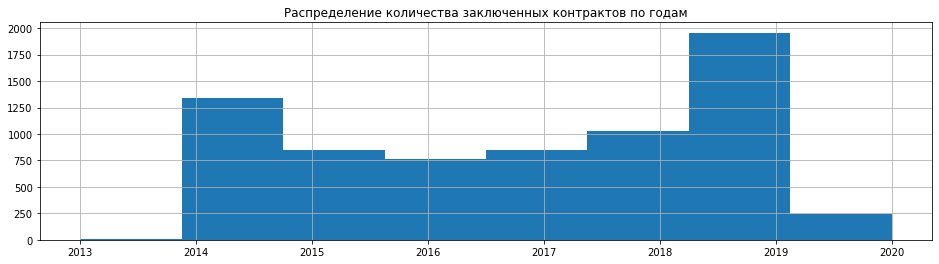

In [27]:
ax = contract.BeginDate.dt.year.hist(
    bins=len(contract.BeginDate.dt.year.unique()),
    figsize=(16, 4))
ax.set_title('Распределение количества заключенных контрактов по годам');

Популярность услуг компании сперва снижалась, потом росла. Небольшие значения крайних столбцов объясняются сбором данных по неполному году.

Исследуем *EndDate*. Его уникальные значения, их количество и доля.

In [28]:
value_counts_presentages(contract.EndDate)

,"Количество, шт","Доля, %"
No,5174,73.46
2019-11-01 00:00:00,485,6.89
2019-12-01 00:00:00,466,6.62
2020-01-01 00:00:00,460,6.53
2019-10-01 00:00:00,458,6.50


Расторжение договора также датируется началом месяца. Все даты распределились между последними тремя месяцами 2019 и январем 2020. Возможно, этим датам предшествовали какие-то изменения в качестве или стоимости услуг.

Даты имеют строковое представление. Также столбец содержит значение "No", что соответствует нерасторжению пользователем договора на 2020-01-01.

Заменим данный признак на время жизни клиента *LTV* &mdash; разницу в днях между *EndDate* и *BegDate*. Значение "No" будем считать соответствующим 2020-02-01 (см. описание проекта).

In [29]:
contract['LTV'] =\
    ((pd.to_datetime(contract.EndDate.replace('No', '2020-02-01 00:00:00')) - contract.BeginDate).dt.days)\
    .astype('int16')

Описательная статистика и гастограмма для вычисленного столбца.

In [30]:
contract.LTV.describe()

count    7043.000000
mean      985.996166
std       747.587844
min         0.000000
25%       273.000000
50%       883.000000
75%      1676.000000
max      2191.000000
Name: LTV, dtype: float64

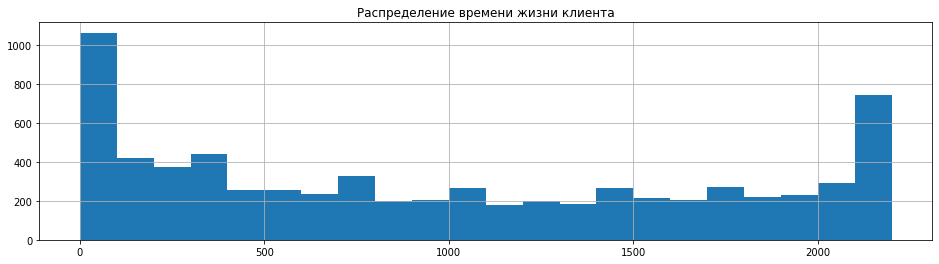

In [31]:
bins = range(100 * int(contract.LTV.min() / 100), 100 * int(contract.LTV.max() / 100 + 2), 100)
ax = contract.LTV.hist(
    bins=bins,
    figsize=(16, 4))
ax.set_title('Распределение времени жизни клиента');

Много клиентов ушло в течении первых 100 дней. Также есть пик в районе максимального значения *LTV*. Есть нулевые значения. Пользователь подключился и отключился в течении одного месяца? Определим их количество.

In [32]:
(contract.LTV == 0).sum()

11

Выведем этих пользователей.

In [33]:
contract[contract.LTV == 0]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,LTV
customerID,,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,0
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,0
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,0
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,0
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,0
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,0
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,0
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,0
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,0


Все эти пользователи подключились в феврале 2020, именно по эти год и месяц в датасете собраны данные, поэтому мы не располагаем информацией о возможном расторжении договора данными клиентами.

Также для представленных клиентов в столбце *TotalCharges* отутствуют значения. Изучим это позже.

Cформируем из столбца *EndDate*  целевой признак *Termination* со значениями True &mdash; на февраль 2020 пользователь расторг контракт, False &mdash; не расторг.

In [34]:
contract['Termination'] = (contract.EndDate != 'No').astype('uint8')

Теперь столбцы *BeginDate* и *EndDate* можно удалить. *BeginDate* логически не связан с причинами возникновения у клиента желания расторгнуть контракт. Более того, даже если разложить *BeginDate* на год и месяц заключения контракта, то их комбинации для новых клиентов окажутся за пределами диапазона значений дат, на которых обучалась модель. В случае *EndDate*, то обучение на предоставленных данных явно приведет к переобучению модели на тех четырех месяцах, в которые фиксировался отток клиентов.

In [35]:
del contract['EndDate']
del contract['BeginDate']

Столбец *Type* с типом оплаты.

Выведем его уникальные значения, их количество и долю.

In [36]:
value_counts_presentages(contract.Type)

,"Количество, шт","Доля, %"
Month-to-month,3875,55.02
Two year,1695,24.07
One year,1473,20.91


Чуть больше половины клиентов предпочитает помесячную оплату. Остальные, поделившись примерно поровну, предпочитают оплачивать услуги на год или на два вперед. Этот столбец будет преобразован на этапе кодирования признаков.

Столбцы *PaperlessBilling* и *PaymentMethod* с информацией о том, является ли расчет безналичным, и способе оплаты.

Рассмотрим первый из них.

In [37]:
value_counts_presentages(contract.PaperlessBilling)

,"Количество, шт","Доля, %"
Yes,4171,59.22
No,2872,40.78


Почти 60% пользователей предпочитают безналичный расчет.

Рассмотрим способ оплаты.

In [38]:
value_counts_presentages(contract.PaymentMethod)

,"Количество, шт","Доля, %"
Electronic check,2365,33.58
Mailed check,1612,22.89
Bank transfer (automatic),1544,21.92
Credit card (automatic),1522,21.61


Большинство клиентов предпочитают электронный счет или счет на почту автоматическому списанию средств.

Столбцы *MonthlyCharges* и *TotalCharges* с информацией о платежах клиентов.

Выведем описательную статистику для столбца с размером ежемесячных платежей *MonthlyCharges*, построим гистограмму.

In [39]:
contract.MonthlyCharges.describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

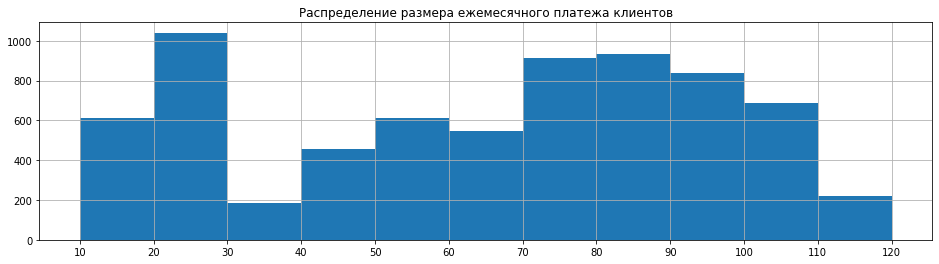

In [40]:
bins = range(10 * int(contract.MonthlyCharges.min() / 10), 10 * int(contract.MonthlyCharges.max() / 10 + 2), 10)
ax = contract.MonthlyCharges.hist(bins=bins, figsize=(16, 4))
ax.set_xticks(bins)
ax.set_title('Распределение размера ежемесячного платежа клиентов');

На общем фоне выделяется группа экономных клиентов.

Как было показано ранее, данный столбец имеет тип `float64`. Такой тип является избыточным для хранения значений ежемесячных платежей, максимальный из которых равен 118.75. Изменим его тип на `float32`.

In [41]:
contract.MonthlyCharges = contract.MonthlyCharges.astype('float32')

Тип столбца с суммарным платежом клиента *TotalCharges* строковый, хотя он хранит числовые значения. Перед преобразованием типа проверим наличие в нем символов, не являющихся цифрами или десятичным разделителем. Подсчитаем их количество.

In [42]:
bad_data_indices = contract.TotalCharges.apply(lambda x: not x.replace('.', '', 1).isdigit())
bad_data_indices.sum()

11

Выведем их.

In [43]:
contract.TotalCharges[bad_data_indices].values

array([' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
      dtype=object)

Как было выяснено раньше, эти значения в столбце *TotalCharges* имеют пользователи, заключившие контракт в феврале 2020 (по эту дату собраны данные в анализируемом датасете). На тот момент эти пользователи еще не успели совершить ни одного платежа, и их суммарный платеж равен 0. Заменим пробелы в столбце *TotalCharges* на 0, а также поменяем тип столбца со строкового на число с плавающей запятой.

In [44]:
contract.loc[bad_data_indices, 'TotalCharges'] = '0'
contract.TotalCharges = contract.TotalCharges.astype('float32')

In [45]:
contract.TotalCharges.describe()

count    7043.000000
mean     2279.734375
std      2266.794434
min         0.000000
25%       398.549988
50%      1394.550049
75%      3786.599976
max      8684.799805
Name: TotalCharges, dtype: float64

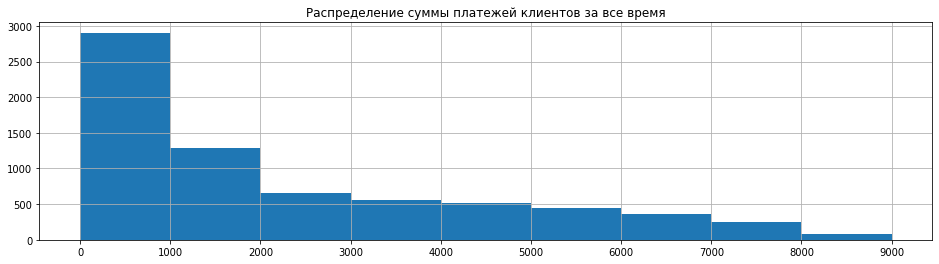

In [46]:
bins = range(1000 * int(contract.TotalCharges.min() / 1000), 1000 * int(contract.TotalCharges.max() / 1000 + 2), 1000)
ax = contract.TotalCharges.hist(bins=bins, figsize=(16, 4))
ax.set_xticks(bins)
ax.set_title('Распределение суммы платежей клиентов за все время');

Теперь таблица **contract** имеет следующий вид:

In [47]:
contract.head(3)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,LTV,Termination
customerID,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.850000,29.850000,31,0
5575-GNVDE,One year,No,Mailed check,56.950001,1889.500000,1036,0
3668-QPYBK,Month-to-month,Yes,Mailed check,53.849998,108.150002,61,1


#### 3.3.2 Таблица personal <a id="3_3_2"></a>

In [48]:
personal.head(3)

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No


Столбец *gender* с информацией о поле клиента.

Выведем количество уникальных значений и их долю.

In [49]:
value_counts_presentages(personal.gender)

,"Количество, шт","Доля, %"
Male,3555,50.48
Female,3488,49.52


Почти поровну.

Столбец *SeniorCitizen* с информацией о том, является ли пользователь пенсионером по возрасту.

In [50]:
value_counts_presentages(personal.SeniorCitizen)

,"Количество, шт","Доля, %"
0,5901,83.79
1,1142,16.21


Доля пенсионеров 16.21 %.

Столбец *Partner* с информацией о наличии у клиента супруга(и).

In [51]:
value_counts_presentages(personal.Partner)

,"Количество, шт","Доля, %"
No,3641,51.7
Yes,3402,48.3


Значения распределены почти поровну.

Столбец *Dependents* с информацией о наличии у клиента иждивенцев.

In [52]:
value_counts_presentages(personal.Dependents)

,"Количество, шт","Доля, %"
No,4933,70.04
Yes,2110,29.96


Почти 30% имеют иждивенцев.

Таблица **personal** после предобработки почти не изменилась. Далее часть ее столбцов с категориальными признаками будет преобразована на этапе кодирования признаков.

In [53]:
personal.head(3)

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No


#### 3.3.3 Таблица internet <a id="3_3_3"></a>

In [54]:
internet.head(3)

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No


Столбцы *InternetService*, *OnlineSecurity*, *OnlineBackup*, *DeviceProtection*, *TechSupport*, *StreamingTV* и *StreamingMovies*.

Выведем в соответствующем порядке их уникальные значения, количество и долю каждого уникального значения.

In [55]:
value_counts_presentages(internet.InternetService)

,"Количество, шт","Доля, %"
Fiber optic,3096,56.12
DSL,2421,43.88


In [56]:
value_counts_presentages(internet.OnlineSecurity)

,"Количество, шт","Доля, %"
No,3498,63.4
Yes,2019,36.6


In [57]:
value_counts_presentages(internet.OnlineBackup)

,"Количество, шт","Доля, %"
No,3088,55.97
Yes,2429,44.03


In [58]:
value_counts_presentages(internet.DeviceProtection)

,"Количество, шт","Доля, %"
No,3095,56.1
Yes,2422,43.9


In [59]:
value_counts_presentages(internet.TechSupport)

,"Количество, шт","Доля, %"
No,3473,62.95
Yes,2044,37.05


In [60]:
value_counts_presentages(internet.StreamingTV)

,"Количество, шт","Доля, %"
No,2810,50.93
Yes,2707,49.07


In [61]:
value_counts_presentages(internet.StreamingMovies)

,"Количество, шт","Доля, %"
No,2785,50.48
Yes,2732,49.52


Данные категориальные столбцы не нуждаются в предобработке и будут преобразованы на этапе кодирования признаков.

#### 3.3.4 Таблица phone <a id="3_3_4"></a>

In [62]:
phone.head(3)

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No


Столбец *MultipleLines* с информацией о том, предоставляет ли телефонный тариф пользователя возможность ведения параллельных линий во время звонка.

In [63]:
value_counts_presentages(phone.MultipleLines)

,"Количество, шт","Доля, %"
No,3390,53.29
Yes,2971,46.71


С небольшим перевесом побеждает тариф без такой возможности. Категориальный столбец *MultipleLines* не требует предобработки и также будет преобразован на этапе кодирования признаков.

### 3.4 Объединение таблиц <a id="3_4"></a>

Объединим все таблицы в одну. Сперва объединим столбцы таблиц **contract**, **personal**. Так как индексы данных таблиц совпадают, ни в одной ячейке результирующей таблицы **data** не появится значения NaN (в исходных таблицах они отсутствуют).

In [64]:
data = contract.join(personal)

Добавим к **data** столбцы таблицы **phone**. Так как длина таблицы **phone** меньше длины таблицы **data**, их объединение по уникальному индексу приведет к появлению в некоторых ячейках единственного столбца *MultipleLines* от таблицы **phone** значений NaN. NaN будет у тех пользователй, которые не пользуются услугами телефонии.

Заполнение этих ячеек одним из значений *MultipleLines* не подходит, т.к. это изменит соотношение клиентов, пользующихся и не пользущихся параллельными линиями, но при этом не добавит в результрующую таблицу **data** информации о клиентах, вообще не пользующихся услугами телефонии.

Заполним образовавшиеся NaN значениями "Nothing".

In [65]:
data = data.join(phone)
data.fillna('Nothing', inplace=True)

Добавим к **data** столбцы таблицы **internet**. Аналогичным образом в столбец *InternetService* объединенной таблицы внесем информацию о том, что клиент не пользуется интернет-услугами. В остальных столбцах, доставшихся от таблицы **internet**, заменим NaN на "No", т.к. формально с интернетом отсутстсвуют и соответствующие дополнительные сервисы.

In [66]:
data = data.join(internet)
data.InternetService.fillna('Nothing', inplace=True)

In [67]:
data.loc[:, ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']]\
    .fillna('No', inplace=True)

Результат объединения таблиц.

In [68]:
data.head(3)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,LTV,Termination,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.850000,29.850000,31,0,Female,0,Yes,No,Nothing,DSL,No,Yes,No,No,No,No
5575-GNVDE,One year,No,Mailed check,56.950001,1889.500000,1036,0,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,Month-to-month,Yes,Mailed check,53.849998,108.150002,61,1,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No


### 3.5 Кодирование признаков <a id="3_5"></a>

Разобъем признаки на три списка:
- количественные признаки;
- категориальные признаки для прямого кодирования;
- категориальные признаки для порядкового кодирования.

Количественные признаки будут масштабированы, категориальные &mdash; закодированы. Выберем для бинарных признаков прямое кодирование, для признаков с 3 и более значениями будем использовать порядковое кодирование, чтобы не увеличивать количество столбцов.

In [69]:
# Количественные признаки
features_quantitative = [
    'MonthlyCharges',
    'TotalCharges',
    'LTV'
]
# Категориальные признаки для прямого кодирования
features_categorical_ohe = [
    'PaperlessBilling',
    'gender',
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies'
]
# Категориальные признаки для порядкового кодирования.
features_categorical_oe = [
    'Type',
    'PaymentMethod',
    'MultipleLines',
    'InternetService'
]
# Все категориальны признаки
features_categorical = features_categorical_ohe + features_categorical_oe
# Все признаки
features = features_categorical + features_quantitative

Закодируем оговоренные категориальные признаки методом прямого кодирования (One-Hot Encoding, OHE).

In [70]:
data = pd.get_dummies(data, columns=features_categorical_ohe, drop_first=True)

Остальные &mdash; методом порядкового кодирования (One-Hot Encoding, OHE).

In [71]:
encoder = OrdinalEncoder()
encoder.fit(data[features_categorical_oe])
data[features_categorical_oe] =\
    pd.DataFrame(
        encoder.transform(data[features_categorical_oe]),
        columns=data[features_categorical_oe].columns,
        index=data[features_categorical_oe].index
)

Отобразим результат кодирования признаков.

In [72]:
data.head(3)

,Type,PaymentMethod,MonthlyCharges,TotalCharges,LTV,Termination,MultipleLines,InternetService,PaperlessBilling_Yes,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0.0,2.0,29.850000,29.850000,31,0,1.0,0.0,1,0,0,1,0,0,1,0,0,0,0
5575-GNVDE,1.0,3.0,56.950001,1889.500000,1036,0,0.0,0.0,0,1,0,0,0,1,0,1,0,0,0
3668-QPYBK,0.0,3.0,53.849998,108.150002,61,1,0.0,0.0,1,1,0,0,0,1,1,0,0,0,0


In [73]:
data.dtypes

Type                    float64
PaymentMethod           float64
MonthlyCharges          float32
TotalCharges            float32
LTV                       int16
Termination               uint8
MultipleLines           float64
InternetService         float64
PaperlessBilling_Yes      uint8
gender_Male               uint8
SeniorCitizen_1           uint8
Partner_Yes               uint8
Dependents_Yes            uint8
OnlineSecurity_Yes        uint8
OnlineBackup_Yes          uint8
DeviceProtection_Yes      uint8
TechSupport_Yes           uint8
StreamingTV_Yes           uint8
StreamingMovies_Yes       uint8
dtype: object

### 3.6 Формирование обучающей и тестовой выборок <a id="3_6"></a>

Разобьем данные на обучающую и тестовую выборки в соотношении 4:1.

In [74]:
train_X, test_X, train_y, test_y = train_test_split(
    data.drop(columns='Termination'),
    data.Termination,
    test_size=0.2,
    random_state=12345,
    shuffle=True
)

### 3.7 Масштабирование признаков <a id="3_7"></a>

Масштабирование количественных признаков в обучающей и тестовой выборках будем проводить с помощью преобразователя масштаба, обученного на обучающей выборке.

In [75]:
scaler = StandardScaler()
scaler.fit(train_X[features_quantitative]) # Обучение только на трейне
train_X[features_quantitative] = scaler.transform(train_X[features_quantitative])
test_X[features_quantitative] = scaler.transform(test_X[features_quantitative])

Результат.

In [76]:
train_X.head(3)

,Type,PaymentMethod,MonthlyCharges,TotalCharges,LTV,MultipleLines,InternetService,PaperlessBilling_Yes,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes
customerID,,,,,,,,,,,,,,,,,,
7108-DGVUU,1.0,0.0,0.227892,-0.349146,-0.467212,2.0,0.0,0,0,1,1,0,0,1,1,0,0,1
1658-TJVOA,0.0,2.0,0.307749,-0.812519,-1.081316,0.0,1.0,1,0,1,0,0,1,0,0,0,0,0
0334-GDDSO,0.0,2.0,0.548983,-0.908724,-1.204943,2.0,1.0,1,1,1,0,0,0,1,0,0,0,0


In [77]:
test_X.head(3)

,Type,PaymentMethod,MonthlyCharges,TotalCharges,LTV,MultipleLines,InternetService,PaperlessBilling_Yes,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes
customerID,,,,,,,,,,,,,,,,,,
0098-BOWSO,0.0,2.0,-1.512322,-0.777572,-0.223990,0.0,2.0,1,1,0,0,0,0,0,0,0,0,0
9992-RRAMN,0.0,2.0,0.673760,-0.182316,-0.430930,2.0,1.0,1,1,0,1,0,0,0,0,0,0,1
8380-PEFPE,0.0,2.0,0.226228,-0.980501,-1.288257,0.0,1.0,1,1,0,0,1,0,0,0,0,0,0


### 3.8 Проверка признаков на мультиколлинеарность <a id="3_8"></a>

Построим матрицу разброса количественных признаков.

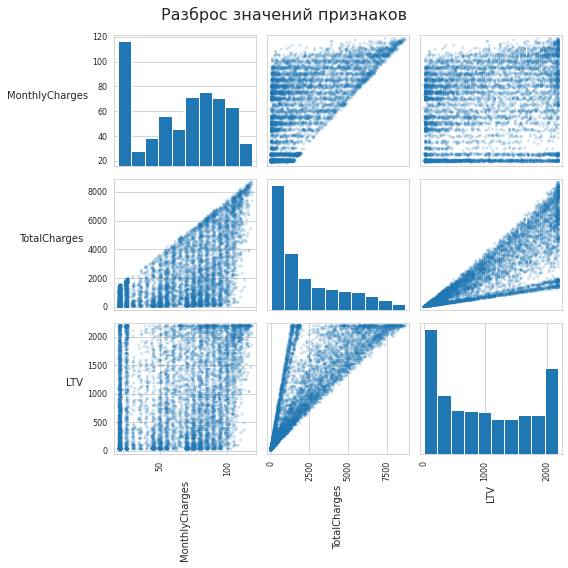

In [78]:
sns.set_style('whitegrid')
axes = pd.plotting.scatter_matrix(data[features_quantitative], alpha=0.2, figsize=(8, 8));
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
plt.suptitle('Разброс значений признаков', fontsize=16);
plt.tight_layout();

Из полученной диаграммы можно предположить, что существует заметная положительная зависимость между признаками *TotalCharges* и *LTV*, что и логично.

Построим тепловую карту со значениями линейного коэффициента корреляции.

In [79]:
corr = data[features_quantitative + ['Termination']].corr()
corr

,MonthlyCharges,TotalCharges,LTV,Termination
MonthlyCharges,1.000000,0.651174,0.247754,0.193356
TotalCharges,0.651174,1.000000,0.826109,-0.198324
LTV,0.247754,0.826109,1.000000,-0.352673
Termination,0.193356,-0.198324,-0.352673,1.000000


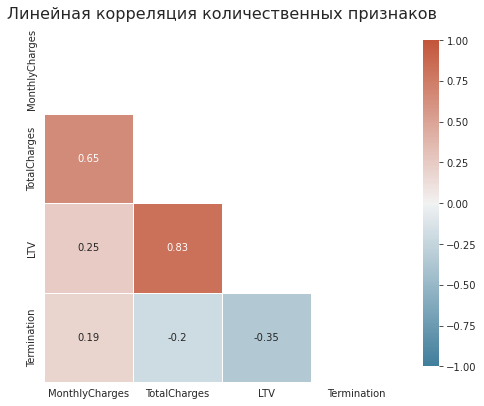

In [80]:
sns.set_style('whitegrid')
_, axs = plt.subplots(figsize=(8, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
    corr, mask=mask, cmap=cmap, annot=True, vmin=-1, vmax=1,
    square=True, linewidths=0.5, cbar_kws={'shrink': 0.75}, ax=axs, fmt='.2g'
).set_title('Линейная корреляция количественных признаков', fontsize=16);

Ожидания подтвердились: *TotalCharges* и *LTV* имеют положительный линейный коэффициент корреляции, равный 0.83. Оставим оба признака.

С целевым признаком опасных корреляций нет.

### 3.9 Анализ и устранение дисбаланса классов <a id="3_9"></a>

Для оценки величины дисбаланса положительного и отрицательного классов в обучающей выборке выведем их доли.

In [81]:
value_counts_presentages(train_y)

,"Количество, шт","Доля, %"
0,4144,73.55
1,1490,26.45


Проверим также баланс классов в тестовой выборке.

In [82]:
value_counts_presentages(test_y)

,"Количество, шт","Доля, %"
0,1030,73.1
1,379,26.9


Соотношение долей приблизительно 1:3.

Борьба с дисбалансом классов достигается как обучением со взвешиванием, так и увеличением (уменьшением) выборки дублированием (удалением) случайным образом объектов меньшего (большего) класса &mdash; upsampling (downsampling). Выведем длину обучающей выборки.

In [83]:
len(train_y)

5634

Количество объектов сравнительно невелико, поэтому увеличение выборки дублированием объектов меньшего положительного класса приведет к приемлемому увеличению ее размера. Сбалансируем обучающую выборку методом upsampling.

In [84]:
random_negative_indices =\
    np.random.choice(train_y[train_y == 1].index, (train_y == 0).sum() - (train_y == 1).sum())
train_y = pd.concat([train_y, train_y[random_negative_indices]])
train_X = pd.concat([train_X, train_X.loc[random_negative_indices]])

Проверим баланс.

In [85]:
value_counts_presentages(train_y)

,"Количество, шт","Доля, %"
0,4144,50.0
1,4144,50.0


Новый размер обучающей выборки.

In [86]:
len(data)

7043

Он соответствует балансу в тренировочной выборке до upsampling.

## 4 Обучение и сравнение моделей <a id="4"></a>

### 4.1 RandomForestClassifier (Scikit Learn) <a id="4_1"></a>

In [87]:
# Скачиваем обученную модель
print(download_file_from_ydisk(MODEL_RFC_PUBLIC_URL, './model_rfc'))

Файл https://disk.yandex.ru/d/C8-3jXGfIjuSVA скачан и сохранен под именем ./model_rfc


In [88]:
# Если дамп модели лежит в папке проекта, то модель загружается из него, если нет - обучается
if os.path.isfile('./model_rfc'):
    rfc_gs = load('./model_rfc')
    print('Модель загружена из файла ./model_rfc')
else:
    # Значения гиперпараметров
    parameters = {
        'n_estimators': [10, 50, 100, 200, 300],
        'max_depth': [1, 10, 50],
        'criterion': ['gini', 'entropy'],
        'min_samples_split': [2, 5, 7, 15],
        'random_state': [12345]
    }
    # Обучение и выбор лучшей модели
    rfc_gs = GridSearchCV(
        RandomForestClassifier(),
        param_grid=parameters,
        scoring='roc_auc',
        cv=5,
        refit=True,
        verbose=0
    )
    rfc_gs.fit(train_X, train_y)
    dump(rfc_gs, 'model_rfc')
    print('Модель обучена и сохранена в файл ./model_rfc')

Модель загружена из файла ./model_rfc


ROC AUC лучшей модели классификатора на основе случайного решающего леса на валидационной выборке.

In [89]:
rfc_gs.best_score_

0.9828548897616498

Гиперпараметры лучшей модели.

In [90]:
rfc_gs.best_params_

{'criterion': 'gini',
 'max_depth': 50,
 'min_samples_split': 2,
 'n_estimators': 300,
 'random_state': 12345}

Значение метрики Accuracy на тестовой выборке.

In [91]:
rfc_accuracy = accuracy_score(test_y, rfc_gs.predict(test_X))
rfc_accuracy

0.808374733853797

Значение метрики ROC AUC на тестовой выборке.

In [92]:
y_pred_prob = rfc_gs.predict_proba(test_X)[:, 1]
rfc_roc_auc = roc_auc_score(test_y, y_pred_prob)
rfc_roc_auc

0.8480928350026898

Соответствующая ROC-кривая.

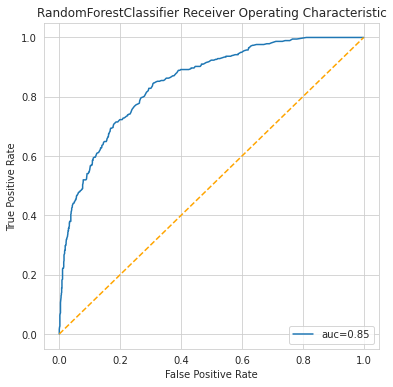

In [93]:
fpr, tpr, _ = roc_curve(test_y, y_pred_prob)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label='auc=' + str(round(rfc_roc_auc, 2)))
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RandomForestClassifier Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Оценка важности признаков лучшей моделью RandomForestClassifier в порядке убывания.

In [94]:
rfc_fi = pd.Series(rfc_gs.best_estimator_.feature_importances_, index=train_X.columns).sort_values(ascending=False)
rfc_fi

LTV                     0.206478
MonthlyCharges          0.167555
TotalCharges            0.166083
Type                    0.118725
PaymentMethod           0.052224
InternetService         0.049585
PaperlessBilling_Yes    0.025932
gender_Male             0.023505
MultipleLines           0.022200
TechSupport_Yes         0.021652
OnlineSecurity_Yes      0.021551
Partner_Yes             0.020142
SeniorCitizen_1         0.019032
Dependents_Yes          0.018864
OnlineBackup_Yes        0.018264
DeviceProtection_Yes    0.017090
StreamingTV_Yes         0.015660
StreamingMovies_Yes     0.015459
dtype: float64

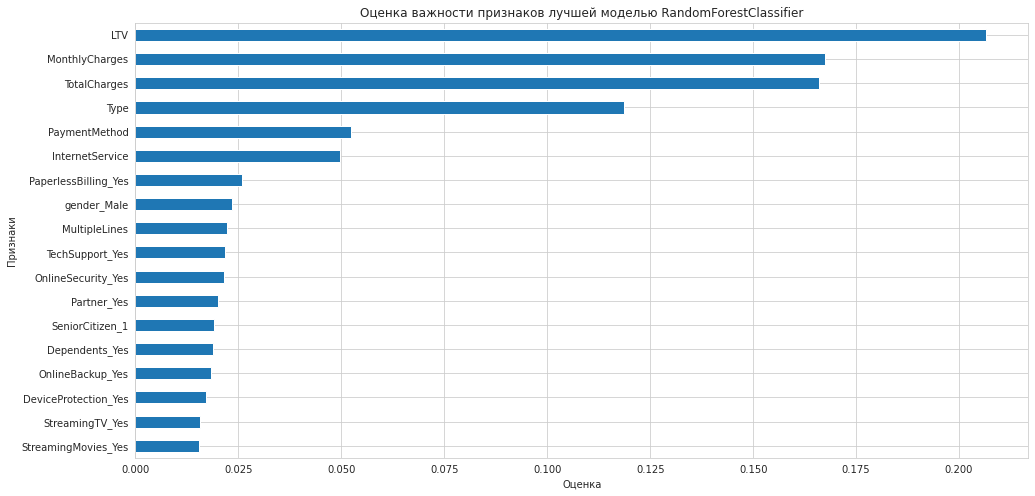

In [95]:
ax = rfc_fi.plot.barh(figsize=(16, 8))
ax.set(xlabel='Оценка', ylabel='Признаки', title='Оценка важности признаков лучшей моделью RandomForestClassifier')
ax.invert_yaxis()

В случае классификатора на основе случайного леса RandomForestClassifier самыми важными признаками стали (по убыванию оценки важности) время жизни клиента *LTV*, размер ежемесячных *MonthlyCharges* и суммарных *TotalCharges* трат на услуги.

С заметными отставанием идут тип *Type* и способ *PaymentMethod* оплаты, а также технология, по которой предоставляется интернет.

Важность остальных признаков заметно ниже.

### 4.2 LogisticRegression (Scikit Learn) <a id="4_2"></a>

In [97]:
# Скачиваем обученную модель
print(download_file_from_ydisk(MODEL_LR_PUBLIC_URL, './model_lr'))

Файл https://disk.yandex.ru/d/9U4TqsUjvENd4w скачан и сохранен под именем ./model_lr


In [98]:
# Если дамп модели лежит в папке проекта, то модель загружается из него, если нет - обучается
if os.path.isfile('./model_lr'):
    lr_gs = load('./model_lr')
    print('Модель загружена из файла ./model_lr')
else:
    # Значения гиперпараметров
    parameters = [
        {
            'solver': ['lbfgs', 'sag'],
            'max_iter': [100, 500],
            'penalty': ['l2'],
            'C': [0.5, 1.0, 2],
            'random_state': [12345]
        },
        {
            'solver': ['liblinear'],
            'max_iter': [100, 500],
            'penalty': ['l1', 'l2'],
            'C': [0.5, 1.0, 2],
            'random_state': [12345]
        },
        {
            'solver': ['saga'],
            'max_iter': [100, 500],
            'penalty': ['l1', 'l2', 'elasticnet'],
            'C': [0.5, 1.0, 2],
            'random_state': [12345]
        }
    ]
    # Обучение и выбор лучшей модели
    lr_gs = GridSearchCV(
        LogisticRegression(),
        param_grid=parameters,
        scoring='roc_auc',
        cv=5,
        refit=True,
        verbose=0
    )
    lr_gs.fit(train_X, train_y)
    dump(lr_gs, 'model_lr')
    print('Модель обучена и сохранена в файл ./model_lr')

Модель загружена из файла ./model_lr


ROC AUC лучшей модели классификатора на основе случайного решающего леса на валидационной выборке.

In [99]:
lr_gs.best_score_

0.8389221578121864

Гиперпараметры лучшей модели.

In [100]:
lr_gs.best_params_

{'C': 0.5,
 'max_iter': 100,
 'penalty': 'l1',
 'random_state': 12345,
 'solver': 'saga'}

Значение метрики Accuracy на тестовой выборке.

In [101]:
lr_accuracy = accuracy_score(test_y, lr_gs.predict(test_X))

Значение метрики ROC AUC на тестовой выборке.

In [102]:
y_pred_prob = lr_gs.predict_proba(test_X)[:, 1]
lr_roc_auc = roc_auc_score(test_y, y_pred_prob)
lr_roc_auc

0.8382022184081769

Соответствующая ROC-кривая.

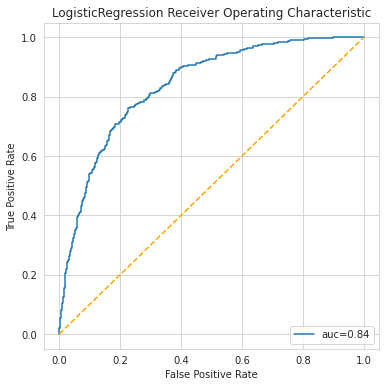

In [103]:
fpr, tpr, _ = roc_curve(test_y, y_pred_prob)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label='auc=' + str(round(lr_roc_auc, 2)))
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LogisticRegression Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Логистическая регрессия LogisticRegression не ранжирует параметры по важности.

### 4.3 LGBMClassifier (LightGBM) <a id="4_3"></a>

In [104]:
# Скачиваем обученную модель
print(download_file_from_ydisk(MODEL_LGBMC_PUBLIC_URL, './model_lgbmc'))

Файл https://disk.yandex.ru/d/3WqsdiT26wL09A скачан и сохранен под именем ./model_lgbmc


In [105]:
# Если дамп модели лежит в папке проекта, то модель загружается из него, если нет - обучается
if os.path.isfile('./model_lgbmc'):
    lgbmc_gs = load('./model_lgbmc')
    print('Модель загружена из файла ./model_lgbmc')
else:
    # Значения гиперпараметров
    parameters = [
        {
            'n_estimators': [50, 100, 200], # Number of boosted trees to fit
            'num_leaves': [11, 31, 91], # Maximum tree leaves for base learners
            'max_depth': [1, 3, 20, -1], # Maximum tree depth for base learners, <=0 means no limit
            'learning_rate': [0.01, 0.1, 1], # Boosting learning rate
            'reg_alpha': [0, 0.1, 5], # L1 regularization term on weights
            'reg_lambda': [0, 0.1, 5] # L2 regularization term on weights
        }
    ]
    # Обучение и выбор лучшей модели
    lgbmc_gs = GridSearchCV(
        LGBMClassifier(),
        param_grid=parameters,
        scoring='roc_auc',
        cv=5,
        refit=True,
        verbose=0
    )
    lgbmc_gs.fit(train_X, train_y)
    dump(lgbmc_gs, 'model_lgbmc')
    print('Модель обучена и сохранена в файл ./model_lgbmc')

Модель загружена из файла ./model_lgbmc


ROC AUC лучшей модели классификатора на основе случайного решающего леса на валидационной выборке.

In [106]:
lgbmc_gs.best_score_

0.9840673510963149

Гиперпараметры лучшей модели.

In [107]:
lgbmc_gs.best_params_

{'learning_rate': 0.1,
 'max_depth': -1,
 'n_estimators': 200,
 'num_leaves': 91,
 'reg_alpha': 0,
 'reg_lambda': 0}

Значение метрики Accuracy на тестовой выборке.

In [108]:
lgbmc_accuracy = accuracy_score(test_y, lgbmc_gs.predict(test_X))
lgbmc_accuracy

0.8559261887863733

Значение метрики ROC AUC на тестовой выборке.

In [109]:
y_pred_prob = lgbmc_gs.predict_proba(test_X)[:, 1]
lgbmc_roc_auc = roc_auc_score(test_y, y_pred_prob)
lgbmc_roc_auc

0.9048505264236493

Соответствующая ROC-кривая.

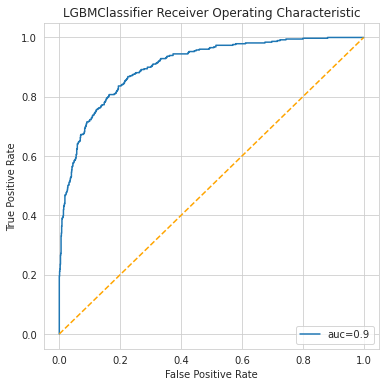

In [110]:
fpr, tpr, _ = roc_curve(test_y, y_pred_prob)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label='auc=' + str(round(lgbmc_roc_auc, 2)))
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LGBMClassifier Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Оценка важности признаков лучшей моделью LGBMClassifier в порядке убывания.

In [111]:
lgbmc_fi = pd.Series(lgbmc_gs.best_estimator_.feature_importances_, index=train_X.columns).sort_values(ascending=False)
lgbmc_fi

MonthlyCharges          4602
LTV                     4579
TotalCharges            3791
PaymentMethod            899
gender_Male              603
Partner_Yes              428
PaperlessBilling_Yes     353
MultipleLines            331
OnlineBackup_Yes         319
Dependents_Yes           309
Type                     295
DeviceProtection_Yes     275
SeniorCitizen_1          241
OnlineSecurity_Yes       232
StreamingTV_Yes          224
TechSupport_Yes          210
StreamingMovies_Yes      199
InternetService          110
dtype: int32

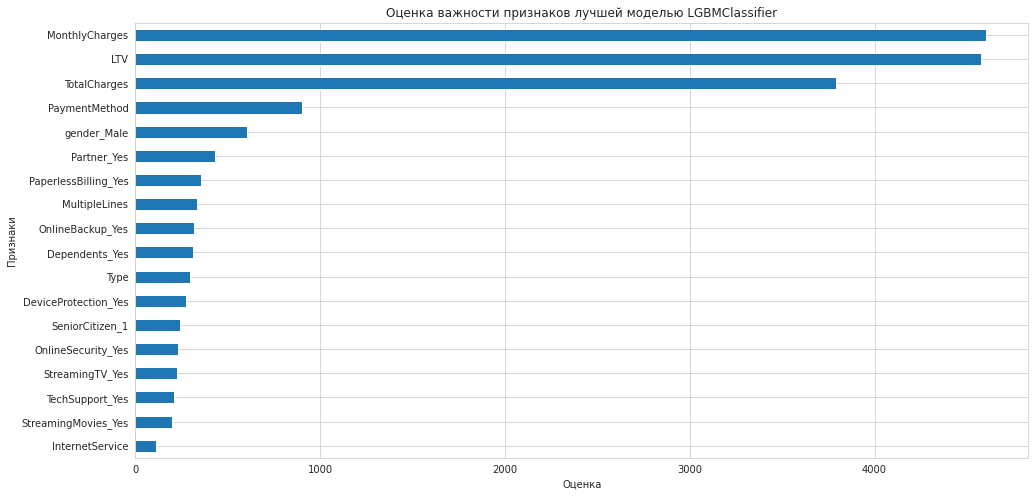

In [112]:
ax = lgbmc_fi.plot.barh(figsize=(16, 8));
ax.set(xlabel='Оценка', ylabel='Признаки', title='Оценка важности признаков лучшей моделью LGBMClassifier')
ax.invert_yaxis()

Лучшая модель LGBMClassifier выделила (в порядке убывания оценки важности) размер ежемесячных трат на услуги *MonthlyCharges*, время жизни клиента *LTV* и суммарные траты на услуги *TotalCharges*.

Оценка важности остальных признаков по сравнению с *TotalCharges* резко падает.

### 4.4 CatBoostClassifier (CatBoost) <a id="4_4"></a>

In [113]:
# Скачиваем обученную модель
print(download_file_from_ydisk(MODEL_CBC_PUBLIC_URL, './model_cbc'))

Файл https://disk.yandex.ru/d/3anbjbPDskaeWA скачан и сохранен под именем ./model_cbc


In [114]:
# Если дамп модели лежит в папке проекта, то модель загружается из него, если нет - обучается
if os.path.isfile('./model_cbc'):
    cbc_gs = load('./model_cbc')
    print('Модель загружена из файла ./model_cbc')
else:
    # Значения гиперпараметров
    parameters = [
        {
            'n_estimators': [50, 100, 200], # Number of boosted trees to fit
            'num_leaves': [11, 31, 91], # Maximum tree leaves for base learners
            'max_depth': [1, 3, 20, -1], # Maximum tree depth for base learners, <=0 means no limit
            'learning_rate': [0.01, 0.1, 1], # Boosting learning rate
            'l2_leaf_reg': [0.1, 1, 3]
        }
    ]
    # Обучение и выбор лучшей модели
    cbc_gs = GridSearchCV(
        CatBoostClassifier(),
        param_grid=parameters,
        scoring='roc_auc',
        cv=5,
        refit=True,
        verbose=0
    )
    cbc_gs.fit(train_X, train_y)
    dump(cbc_gs, 'model_cbc')
    print('Модель обучена и сохранена в файл ./model_cbc')

Модель загружена из файла ./model_cbc


ROC AUC лучшей модели классификатора на основе случайного решающего леса на валидационной выборке.

In [115]:
cbc_gs.best_score_

0.9647510967100426

Гиперпараметры лучшей модели.

In [116]:
cbc_gs.best_params_

{'l2_leaf_reg': 3,
 'learning_rate': 1,
 'max_depth': 3,
 'n_estimators': 200,
 'num_leaves': 31}

Значение метрики Accuracy на тестовой выборке.

In [117]:
cbc_accuracy = accuracy_score(test_y, cbc_gs.predict(test_X))
cbc_accuracy

0.8545067423704755

Значение метрики ROC AUC на тестовой выборке.

In [118]:
y_pred_prob = cbc_gs.predict_proba(test_X)[:, 1]
cbc_roc_auc = roc_auc_score(test_y, y_pred_prob)
cbc_roc_auc

0.9143581730153445

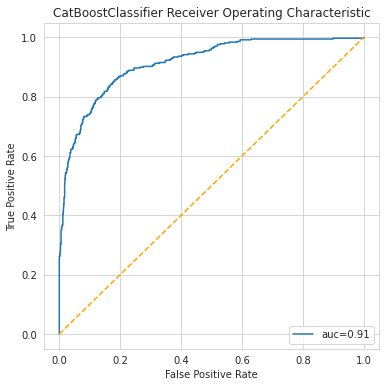

In [119]:
fpr, tpr, _ = roc_curve(test_y, y_pred_prob)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label='auc=' + str(round(cbc_roc_auc, 2)))
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CatBoostClassifier Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Оценка важности признаков лучшей моделью CatBoostClassifier в порядке убывания.

In [120]:
cbc_fi = pd.Series(cbc_gs.best_estimator_.feature_importances_, index=train_X.columns).sort_values(ascending=False)
cbc_fi

LTV                     61.221675
MonthlyCharges          12.735841
TotalCharges            10.387000
Type                     6.951193
PaymentMethod            1.710528
StreamingMovies_Yes      0.851920
SeniorCitizen_1          0.828482
MultipleLines            0.795537
OnlineSecurity_Yes       0.692515
Dependents_Yes           0.685369
PaperlessBilling_Yes     0.680052
OnlineBackup_Yes         0.469310
TechSupport_Yes          0.456509
InternetService          0.456459
gender_Male              0.380872
Partner_Yes              0.239437
StreamingTV_Yes          0.237347
DeviceProtection_Yes     0.219957
dtype: float64

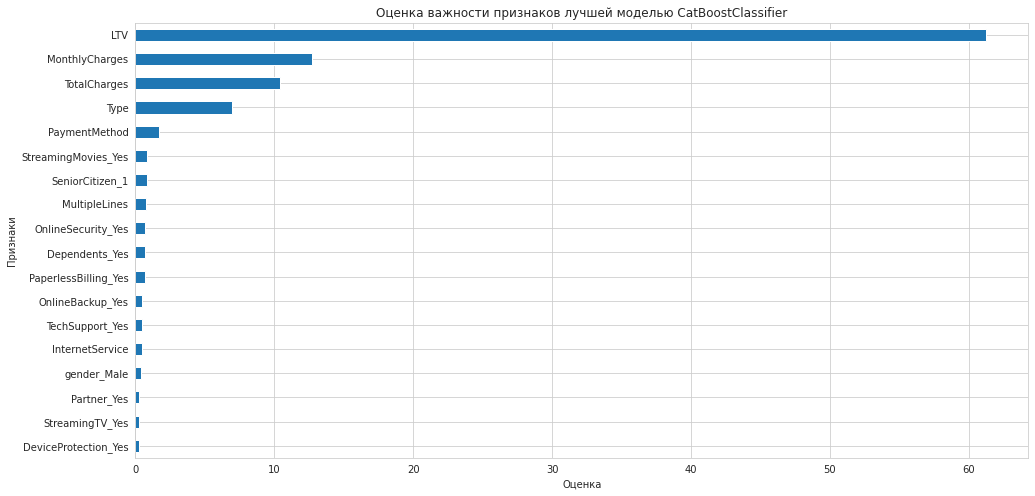

In [121]:
ax = cbc_fi.plot.barh(figsize=(16, 8))
ax.set(xlabel='Оценка', ylabel='Признаки', title='Оценка важности признаков лучшей моделью CatBoostClassifier')
ax.invert_yaxis()

Лучшая модель CatBoostClassifier выделяет четыре самых важных признака: время жизни клиента *LTV*, размер ежемесячных *MonthlyCharges* и суммарных *TotalCharges* трат и тип платежа *Type*. При этом *LTV* лидирует с огромным отрывом.

Важность остальных признаков на фоне первых четырех незначительна.

### 4.5 DummyClassifier (Scikit Learn) <a id="4_5"></a>

Обучим примитивный классификатор со стратегией "самый часто встречающийся класс".

In [122]:
dc = DummyClassifier(strategy="most_frequent")
dc.fit(train_X, train_y)

DummyClassifier(strategy='most_frequent')

Значение метрики ROC AUC на тестовой выборке.

In [123]:
y_pred_prob = dc.predict_proba(test_X)[:, 1]
dc_roc_auc = roc_auc_score(test_y, y_pred_prob)
dc_roc_auc

0.5

Логично. :)

Значение метрики Accuracy на тестовой выборке.

In [124]:
dc_accuracy = accuracy_score(test_y, dc.predict(test_X))
dc_accuracy

0.7310149041873669

### 4.6 Сравнение и выбор лучшей модели <a id="4_6"></a>

Сведем полученные данные в таблицу для сравнения эффективности моделей.

In [125]:
pd.DataFrame(
    [
        [rfc_roc_auc, rfc_accuracy] + list(rfc_fi.index[0:5]),
        [lr_roc_auc, lr_accuracy] + ['—']*5,
        [lgbmc_roc_auc, lgbmc_accuracy] + list(lgbmc_fi.index[0:5]),
        [cbc_roc_auc, cbc_accuracy] + list(cbc_fi.index[0:5]),
        [dc_roc_auc, dc_accuracy] + ['—']*5,
    ],
    index=[
        'RandomForestClassifier',
        'LogisticRegression',
        'LGBMClassifier',
        'CatBoostClassifier',
        'DummyClassifier'
    ],
    columns=[
        'ROC AUC на тесте',
        'Accuracy на тесте',
        'Important feature №1',
        'Important feature №2',
        'Important feature №3',
        'Important feature №4',
        'Important feature №5'
    ]
).sort_values(by='ROC AUC на тесте', ascending=False)

,ROC AUC на тесте,Accuracy на тесте,Important feature №1,Important feature №2,Important feature №3,Important feature №4,Important feature №5
CatBoostClassifier,0.914358,0.854507,LTV,MonthlyCharges,TotalCharges,Type,PaymentMethod
LGBMClassifier,0.904851,0.855926,MonthlyCharges,LTV,TotalCharges,PaymentMethod,gender_Male
RandomForestClassifier,0.848093,0.808375,LTV,MonthlyCharges,TotalCharges,Type,PaymentMethod
LogisticRegression,0.838202,0.732434,—,—,—,—,—
DummyClassifier,0.500000,0.731015,—,—,—,—,—


## 5 Вывод <a id="5"></a>

Был проведен сравнительный анализ эффективности моделей машинного обучения для прогнозирования оттока клиентов оператора связи «Ниединогоразрыва.ком».

Обучение моделей проводилось на данных, собранных в период с 2013-10-01 по 2020-02-01 и представленных в виде таблиц **contract**, **persoal**, **internet** и **phone**.

Данные были загружены и предобработаны. На этапе предобработки были добавлены признаки "время жизни клиента" *LTV*, вычисленный на основе признаков *EndDate* и *BeginDate*, и целевой признак "расторжение контракта" *Termination*, вычисленный на основе признака *EndDate*. Признаки *BeginDate* и *EndDate* были удалены из набора данных.

Предобработанные данные были объединены в таблицу **data**, после чего категориальные признаки были закодированы: если  признак содержал две категории, использовалось прямое кодирование (One-Hot Encoding, унитарный код), если больше &mdash; ранговое.

Из закодированных данных были сформированы обучающая и тестовая выборки в соотношении 4:1.

Количественные признаки обучающей и тестовой выборок были масштабированы с помощью преобразователя масштаба, обученного на обучающей выборке.

Также количественные признаки были проверены на мультиколлинеарность: значений каждой пары признаков были отображены на диаграмме рассеяния. Также для каждой пары количественных признаков был вычислен линейный коэффициент корреляции Пирсона. Для их визуализации использовалась тепловая карта. Критически выскокой корреляции между собой и с целевым признаком обнаружено небыло.

Также был проведен анализ дисбаланса классов в обучающей выборке. Отрицательный класс имел заметный перевес. Примерно 3:1. Балансировка была достигнута увеличением количества объектов меньшего положительного класса (upsampling).

Для бинарной классификации были выбраны следующие распространенные модели:
- случайный решающий лес RandomForestClassifier библиотеки Scikit Learn;
- логистическая регрессия LogisticRegression библиотеки Scikit Learn;
- случайный решающий лес LGBMClassifier библиотеки LightGBM;
- случайный решающий лес CatBoostClassifier библиотеки CatBoost.

Обучение осуществлялось для разных комбинаций гиперпараметров, использовалась кросс-валидация 4:1, при обучении оценка качества проводилась с помощью метрики ROC AUC. Каждая модель с лучшими гиперпараметрами проверялась на тестовой выборке, для чего вычислялись значения метрик ROC AUC и Accuracy. Для "деревянных" моделей выводился список признаков, ранжированный по оценке важности.

Обученные модели сравнивались между собой и с примитивным классификатором DummyClassifier, использующим стратегию "самый часто встречающийся класс".

Все модели оказались гораздо эффективней примитивного классификатора. В порядке уменьшения значения ROC AUC на тестовых данных:

| Model | ROC AUC | Accurace |
| --- | ----------- | ----------- |
| CatBoostClassifier | 0.914358 | 0.854507 |
| LGBMClassifier | 0.904851 | 0.855926 |
| RandomForestClassifier | 0.848093 | 0.808375 |
| LogisticRegression | 0.838202 | 0.732434 |
| DummyClassifier | 0.500000 | 0.731015 |

Модель CatBoostClassifier показала наивысшую эффективность, достигнув значения ROC AUC 0.91.

## 6 Чек-лист готовности проекта <a id="6"></a>

- [x] Выполнена загрузка и подготовка данных
- [x] Выполнено обучение моделей и сравнение их эффективности
- [x] Выбрана лучшая модель
- [x] Написан вывод

## 7 Отчет<a id="7"></a>

Какие пункты плана были выполнены, а какие — нет:
- удален пункт обучения и тестирования модели RidgeClassifier библиотеки Scikit Learn. Рассматривал RidgeClassifier, т.к. хотел попробовать разные виды регуляризации (L1, L2, elasticnet), но из документации оказалось, что модель LogisticRegression библиотеки Scikit Learn их все поддерживает. Поэтому решил остановиться на LogisticRegression;
- удален пункт "Тестирование лучшей модели". В нем я хотел переобучить модель на полной тренировочной выборке, но позже уточнил в документации, что при выставлении в методе GridSearchCV() библиотеки Scikit Learn флага refit в True для лучшей модели это происходит автоматически;
- некоторые пункты 3.x изменили порядок. Это связано с оптимизацией вычислений.

Какие трудности возникли:
- модель сильно переобучалась на данных, содержащих месяц даты заключения договора. Логистическая регрессия даже показывала ROC AUC и Accuracy, равные 1. Удалил этот признак. Единственным признаком, косвенно содержащим информацию о времени, остался вычисленный признак "время жизни клиента" *LTV*. После этого модели стали показывать более естественный для непереобученных моделей результат;
- частый перезапуск проекта с долго обучающимися моделями потребовал скопипащивания из одного из моих старых проектов функций для загрузки дампов моделей с Яндекс.Диска.

Какие ключевые шаги в решении задачи:
- предобработка и объединение данных в одну таблицу.

Итоговая модель и ее качество:
- лучший результат бинарной классификации показала модель CatBoostClassifier, она достигла ROC AUC = 0.91 и Accuracy = 0.85.